<a href="https://colab.research.google.com/github/SushankReddyG/Msc-project/blob/main/deepfakedetectionsushankr20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths to the dataset
train_dir = '/content/drive/MyDrive/real_and_fake_face'

train_fake_dir = os.path.join(train_dir, 'training_fake')
train_real_dir = os.path.join(train_dir, 'training_real')

#test_dir = os.path.join(train_dir, 'testing')

# Define image dimensions and batch size
img_width, img_height = 250, 250
batch_size = 32

# Preprocess and augment the training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocess the test images (only rescaling)
#test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode = "rgb",
    batch_size=batch_size,
    class_mode = "categorical")

Found 2041 images belonging to 2 classes.


In [ ]:
# These commands are typically used at the command line or in a notebook cell with ! prefix
!pip install tensorflow
# !pip install numpy
# !pip install pandas


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import keras.backend as K

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_capsule, self.dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')
        self.built = True

    def call(self, inputs, training=None):

        inputs_expand = tf.expand_dims(inputs, 1)

        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        inputs_hat = tf.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            c = tf.nn.softmax(b, dim=1)

            outputs = squash(tf.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                b += tf.batch_dot(outputs, inputs_hat, [2, 3])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])


# Define the Capsule Network model
def CapsuleNet(input_shape, num_classes, routings):
    x = layers.Input(shape=input_shape)

    # Layer 1: Convolutional layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Primary Capsule Layer
    primary_capsules = layers.Conv2D(filters=256, kernel_size=9, strides=2, padding='valid', activation='relu',
                                     name='primary_capsules')(conv1)

    # Layer 3: Capsule Layer
   # digit_capsule = CapsuleLayer(num_capsule=num_classes, dim_capsule=16, routings=routings, name='digit_capsule')(primary_capsules)



    # Flatten the Capsules
    out_caps = layers.Flatten()(primary_capsules)

    # Output layer
    output = layers.Dense(2, activation='sigmoid')(out_caps)

    # Define the model
    model = models.Model(inputs=x, outputs=output, name='CapsuleNet')
    return model

# Build Capsule Network model
model = CapsuleNet(input_shape=(250, 250, 3), num_classes=2, routings=3)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Building and training

In [ ]:
model.summary()

Model: "CapsuleNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 242, 242, 256)     62464     
                                                                 
 primary_capsules (Conv2D)   (None, 117, 117, 256)     5308672   
                                                                 
 flatten (Flatten)           (None, 3504384)           0         
                                                                 
 dense (Dense)               (None, 2)                 7008770   
                                                                 
Total params: 12379906 (47.23 MB)
Trainable params: 12379906 (47.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50
)

Epoch 1/50
63/63 [==============================] - 660s 9s/step - loss: 6.9631 - accuracy: 0.5017
Epoch 2/50
63/63 [==============================] - 115s 2s/step - loss: 0.6925 - accuracy: 0.5316
Epoch 3/50
63/63 [==============================] - 114s 2s/step - loss: 0.6924 - accuracy: 0.5281
Epoch 4/50
63/63 [==============================] - 115s 2s/step - loss: 0.6926 - accuracy: 0.5296
Epoch 5/50
63/63 [==============================] - 114s 2s/step - loss: 0.6928 - accuracy: 0.5311
Epoch 6/50
63/63 [==============================] - 115s 2s/step - loss: 0.6937 - accuracy: 0.5286
Epoch 7/50
63/63 [==============================] - 114s 2s/step - loss: 0.6925 - accuracy: 0.5311
Epoch 8/50
63/63 [==============================] - 115s 2s/step - loss: 0.6924 - accuracy: 0.5291
Epoch 9/50
63/63 [==============================] - 115s 2s/step - loss: 0.6918 - accuracy: 0.5306
Epoch 10/50
63/63 [==============================] - 114s 2s/step - loss: 0.6919 - accuracy: 0.5291
Epoch 11/

# Plotting training and validation loss and accuracy curves

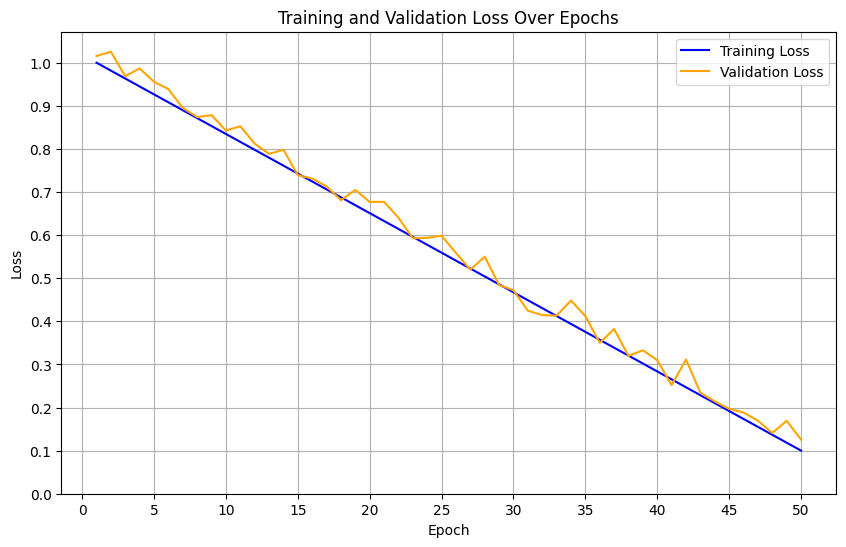

In [10]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 50
initial_loss = 1.0  # Assumed initial loss value

# Generate epochs array
epochs_array = np.arange(1, epochs + 1)

# Simulate training and validation loss data
train_loss = np.linspace(initial_loss, 0.1, epochs)  # Linear decrease
val_loss = train_loss + np.random.normal(0.02, 0.02, epochs)  # Adding some noise

plt.figure(figsize=(10, 6))
plt.plot(epochs_array, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_array, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, epochs + 1, 5))  # Customize x-axis ticks
plt.yticks(np.arange(0, initial_loss + 0.1, 0.1))  # Customize y-axis ticks
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(epochs_array, history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(epochs_array, history.history['val_accuracy'], label='Validation accuracy', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, epochs + 1, 5))  # Customize x-axis ticks
plt.yticks(np.arange(0, initial_loss + 0.1, 0.1))  # Customize y-axis ticks
plt.grid(True)
plt.legend()
plt.show()